* The data we used came from TCGA data collated by UCSC Xena, so CNA has been converted as gene-level form. 

In [1]:
import os
import copy
from math import inf, ceil
import shutil

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
NA_MAP = {
    "[Discrepancy]": np.NaN,
    "[Not Available]": np.NaN,
    "[Not Applicable]": np.NaN,
    "[Completed]": np.NaN,
    "not reported": np.NaN
}

STAGE_MAP_INV = {
    "I": ["Stage I", "Stage IA", "Stage IB", "Stage IB1", "Stage IS", "Stage IC", "Stage IB2", "Stage IA1", "Stage IA2", "stage i"],
    "II": ["Stage II", "Stage IIB", "Stage IIA", "Stage IIC", "IIb", "Stage IIA2", "Stage IIA1", "IIa", "stage ii"],
    "III": ["Stage IIIC", "Stage III", "Stage IIIB", "Stage IIIA", "Stage IIIC2", "Stage IIIC1", "stage iii"],
    "IV": ["Stage IVA", "Stage IV", "Stage IVB", "Stage IVC", "IVb", "IVa", "stage iv"],
    "X": ['Stage X'],
    np.NaN: ['Stage 0', 'I or II NOS']
}

T_MAP_INV = {
    "T0": ['T0', ],
    "T1": ['T1', 'T1a', 'T1b', 'T1c'],
    "T2": ['T2', 'T2a', 'T2b'],
    "T3": ['T3', 'T3a', 'T3b', 'T3c'],
    "T4": ['T4', 'T4a', 'T4b', 'T4c', 'T4d', 'T4e'],
    np.NaN: ['TX', 'Tis']
}

N_MAP_INV = {
    "N0": ['N0', 'N0 (mol+)', 'N0 (i+)', 'N0 (i-)'],
    "N1": ['N1', 'N1a', 'N1b', 'N1c', 'N1mi'],
    "N2": ['N2', 'N2a', 'N2b', 'N2c'],
    "N3": ['N3', 'N3a', 'N3b', 'N3c'],
    np.NaN: ['NX']
}

M_MAP_INV = {
    "M0": ['M0', 'cM0 (i+)'],
    "M1": ['M1', 'M1a', 'M1b', 'M1c'],
    np.NaN: ['MX']
}

STAGE_MAP, T_MAP, N_MAP, M_MAP = {}, {}, {}, {}
for map_inv, map_ in zip(
    [STAGE_MAP_INV, T_MAP_INV, N_MAP_INV, M_MAP_INV],
    [STAGE_MAP, T_MAP, N_MAP, M_MAP]
):
    for k, vs in map_inv.items():
        for v in vs:
            map_[v] = k

# Preprocess PanCancer Dataset

In [6]:
ROOT = "/mnt/data1/share_data/TCGA/ori/PAN_UCSC/"
SAVE_ROOT = "/mnt/data1/share_data/TCGA/PAN2/"
TEMP_ROOT = "/mnt/data1/share_data/TCGA/PAN2_temp/"
# feat_dir = os.path.join(SAVE_ROOT, "fea", "PAN")
# clinic_dir = os.path.join(SAVE_ROOT, "clinic")
# os.makedirs(feat_dir, exist_ok=True)
# os.makedirs(clinic_dir, exist_ok=True)
os.makedirs(SAVE_ROOT, exist_ok=True)
os.makedirs(TEMP_ROOT, exist_ok=True)

## remove features with too many NAs

In [8]:
# 这里不需要对index进行索引，因为这里直接slice的是dataframe，不是ndarray
def clean_features(
    fn, save_fn, nfeat, na_thre=0.8, rows_per_reads=None, totallines=None
):
    # fn = os.path.join(ROOT, fn)
    if rows_per_reads is None:
        print("reading ...")
        dfexp = pd.read_table(fn, index_col=0)
        print("reading finsh.")
        print("shape = %s" % str(dfexp.shape))
        print(dfexp.iloc[:5, :5])
        print("value max = %.4f, min = %.4f" %
              (np.nanmax(dfexp.values), np.nanmin(dfexp.values)))

        # 1. 删除其中缺失值超过80%的genes
        nasum = dfexp.isna().mean(axis=1)
        dfexp = dfexp.loc[nasum < na_thre, :]
        print("shape = %s" % str(dfexp.shape))
        # 2. 通过方差保留3217个genes
        sigma = dfexp.std(axis=1)
        print("std max = %.4f, min = %.4f" % (sigma.max(), sigma.min()))
        ind = (-sigma).argsort().iloc[:nfeat]
        dfexp = dfexp.iloc[ind, :]
        newsigma = dfexp.std(axis=1)
        print("std max = %.4f, min = %.4f" % (newsigma.max(), newsigma.min()))
    else:
        print("iterative reading ...")
        if totallines is not None:
            nchunks = ceil(totallines / rows_per_reads)
        else:
            nchunks = None
        reader = pd.read_table(fn, index_col=0, chunksize=rows_per_reads)
        ma, mi, keepn, totaln, nainds, sigma = -inf, inf, 0, 0, [], []
        sigmama, sigmami = -inf, inf
        for dfi in tqdm(reader, total=nchunks):
            # 计算最大值和最小值
            ma = max(ma, np.nanmax(dfi.values))
            mi = min(mi, np.nanmin(dfi.values))
            # 去除缺失值
            nasum = dfi.isna().mean(axis=1)
            naind = nasum < na_thre
            nainds.append(naind)
            keepn += naind.sum()
            totaln += dfi.shape[0]
            # 计算标准差
            dfii = dfi.loc[naind, :]
            sigmai = dfii.std(axis=1)
            sigma.append(sigmai)
            sigmama = max(sigmama, np.nanmax(sigmai.values))
            sigmami = min(sigmami, np.nanmin(sigmai.values))

        print("shape = (%d, %d)" % (totaln, dfi.shape[1]))
        print("value max = %.4f, min = %.4f" % (ma, mi))
        print("std max = %.4f, min = %.4f" % (sigmama, sigmami))

        print("sorting ...")
        sigma = pd.concat(sigma, axis=0)
        ind = (-sigma).argsort().iloc[:nfeat]
        print("sort finish.")

        start = 0
        res = []
        sigmama, sigmami = -inf, inf
        reader = pd.read_table(fn, index_col=0, chunksize=rows_per_reads)
        for i, dfi in tqdm(enumerate(reader), total=nchunks):
            dfii = dfi.loc[nainds[i], :]
            end = start + dfii.shape[0]
            indi = ind[(ind >= start).values & (ind < end).values]
            if indi.shape[0] == 0:
                continue
            dfiii = dfii.iloc[indi - start, :]
            res.append(dfiii)
            sigmai = dfiii.std(axis=1)
            sigmama = max(sigmama, np.nanmax(sigmai.values))
            sigmami = min(sigmami, np.nanmin(sigmai.values))
            start = end
        print("std max = %.4f, min = %.4f" % (sigmama, sigmami))
        res = pd.concat(res)
        # print("shape = %s" % str(res.shape))
        # res.to_csv(os.path.join(ROOT, save_name))
        dfexp = res

    # 3. 使用均值填补缺失值
    print("imputing...")
    imputer = SimpleImputer()
    newarr = imputer.fit_transform(dfexp.T)
    newdfexp = pd.DataFrame(newarr.T,
                            index=dfexp.index,
                            columns=dfexp.columns)
    print("imputation finish.")
    # 4. 保存
    print("shape = %s" % str(newdfexp.shape))
    newdfexp.to_csv(save_fn)

In [11]:
for name, fn, nfeats in zip(
    ["rna", "miRNA", "CN", "meth"],
    [
        "EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena",
        "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena",
        "TCGA.PANCAN.sampleMap%2FGistic2_CopyNumber_Gistic2_all_data_by_genes", 
        "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena"
    ],
    [3217, 383, 3105, 3139]
):
    print("%s..." % name)
    fn = os.path.join(ROOT, fn)
    save_fn = os.path.join(TEMP_ROOT, "%s_unmerged.csv" % name)
    if name == "meth":
        clean_features(fn, save_fn, nfeats, 0.2, rows_per_reads=5000, totallines=396066)
    else:
        clean_features(fn, save_fn, nfeats, 0.2)

rna...
reading ...
reading finsh.
shape = (20531, 11069)
           TCGA-OR-A5J1-01  TCGA-OR-A5J2-01  TCGA-OR-A5J3-01  TCGA-OR-A5J5-01  \
sample                                                                          
100130426             0.00             0.00             0.00             0.00   
100133144             2.09             1.88             1.45             0.00   
100134869             2.30             3.32             2.92             1.35   
10357                 7.23             6.36             6.45             5.78   
10431                10.99            10.35            10.04            11.20   

           TCGA-OR-A5J6-01  
sample                      
100130426             0.00  
100133144             0.00  
100134869             2.45  
10357                 6.09  
10431                10.30  
value max = 23.2400, min = -6.8300
shape = (20531, 11069)
std max = 5.8411, min = 0.0000
std max = 5.8411, min = 2.1948
imputing...
imputation finish.
shape = (3217, 11069)

100%|██████████| 80/80 [23:43<00:00, 17.79s/it]


shape = (396065, 9664)
value max = 1.0000, min = 0.0000
std max = 0.4209, min = 0.0021
sorting ...
sort finish.


100%|██████████| 80/80 [27:01<00:00, 20.27s/it]


std max = 0.4209, min = 0.2839
imputing...
imputation finish.
shape = (3139, 9664)


## preprocess clinical variables

### keep most samples

In [7]:
clinic_name = "Survival_SupplementalTable_S1_20171025_xena_sp"
clinic_fn = os.path.join(ROOT, clinic_name)
save_clinic_fn = os.path.join(TEMP_ROOT, "clinic_unmerged.csv")

need_vars = [
    "OS", "OS.time", "age_at_initial_pathologic_diagnosis", "gender",
    "clinical_stage", "cancer type abbreviation"
]
varrename = {
    "OS": "status",
    "OS.time": "days",
    "clinical_stage": "pathologic_stage",
    "cancer type abbreviation": "label"
}

In [8]:
# 临床信息
df_clinic = pd.read_table(clinic_fn, index_col=0)
df_clinic = df_clinic.loc[:, need_vars]
df_clinic = df_clinic.rename(columns=varrename)
df_clinic.head()

,status,days,age_at_initial_pathologic_diagnosis,gender,pathologic_stage,label
sample,,,,,,
TCGA-OR-A5J1-01,1.0,1355.0,58.0,MALE,NaN,ACC
TCGA-OR-A5J2-01,1.0,1677.0,44.0,FEMALE,NaN,ACC
TCGA-OR-A5J3-01,0.0,2091.0,23.0,FEMALE,NaN,ACC
TCGA-OR-A5J4-01,1.0,423.0,23.0,FEMALE,NaN,ACC
TCGA-OR-A5J5-01,1.0,365.0,30.0,MALE,NaN,ACC


In [9]:
df_clinic.shape, df_clinic.label.unique().shape

((12591, 6), (33,))

In [10]:
df_use = df_clinic
df_use.head()

,status,days,age_at_initial_pathologic_diagnosis,gender,pathologic_stage,label
sample,,,,,,
TCGA-OR-A5J1-01,1.0,1355.0,58.0,MALE,NaN,ACC
TCGA-OR-A5J2-01,1.0,1677.0,44.0,FEMALE,NaN,ACC
TCGA-OR-A5J3-01,0.0,2091.0,23.0,FEMALE,NaN,ACC
TCGA-OR-A5J4-01,1.0,423.0,23.0,FEMALE,NaN,ACC
TCGA-OR-A5J5-01,1.0,365.0,30.0,MALE,NaN,ACC


### keep primary samples

In [52]:
pheno_name = "TCGA_phenotype_denseDataOnlyDownload.tsv"
pheno_fn = os.path.join(ROOT, pheno_name)
df_pheno = pd.read_table(pheno_fn, index_col=0)
df_pheno.head()

,sample_type_id,sample_type,_primary_disease
sample,,,
TCGA-D3-A1QA-07,7.0,Additional Metastatic,skin cutaneous melanoma
TCGA-DE-A4MD-06,6.0,Metastatic,thyroid carcinoma
TCGA-J8-A3O2-06,6.0,Metastatic,thyroid carcinoma
TCGA-J8-A3YH-06,6.0,Metastatic,thyroid carcinoma
TCGA-EM-A2P1-06,6.0,Metastatic,thyroid carcinoma


In [53]:
# 合并
df_merged = df_clinic.merge(df_pheno, how="outer", right_index=True, left_index=True)
df_merged.head()

,status,days,age_at_initial_pathologic_diagnosis,gender,pathologic_stage,label,sample_type_id,sample_type,_primary_disease
sample,,,,,,,,,
TCGA-01-0628-11,NaN,NaN,NaN,NaN,NaN,NaN,11.0,Solid Tissue Normal,ovarian serous cystadenocarcinoma
TCGA-01-0629-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ovarian serous cystadenocarcinoma
TCGA-01-0630-11,NaN,NaN,NaN,NaN,NaN,NaN,11.0,Solid Tissue Normal,ovarian serous cystadenocarcinoma
TCGA-01-0631-11,NaN,NaN,NaN,NaN,NaN,NaN,11.0,Solid Tissue Normal,ovarian serous cystadenocarcinoma
TCGA-01-0633-11,NaN,NaN,NaN,NaN,NaN,NaN,11.0,Solid Tissue Normal,ovarian serous cystadenocarcinoma


In [57]:
# 只选择其中的原发癌部分，并增加一个Solid Tissue Normal (癌旁)类别
ind = df_merged.sample_type.isin(["Primary Blood Derived Cancer - Peripheral Blood", "Primary Tumor", "Solid Tissue Normal"])
df_use = df_merged.loc[ind, :].copy()
df_use.loc[:, "label"] = df_use._primary_disease.copy()
df_use.loc[df_use.sample_type == "Solid Tissue Normal", "label"] = "Solid Tissue Normal"
df_use = df_use.loc[:, list(varrename.values())]
df_use.head()

,status,days,pathologic_stage,label
sample,,,,
TCGA-01-0628-11,NaN,NaN,NaN,Solid Tissue Normal
TCGA-01-0630-11,NaN,NaN,NaN,Solid Tissue Normal
TCGA-01-0631-11,NaN,NaN,NaN,Solid Tissue Normal
TCGA-01-0633-11,NaN,NaN,NaN,Solid Tissue Normal
TCGA-01-0636-11,NaN,NaN,NaN,Solid Tissue Normal


In [ ]:
df_use.to_csv(save_clinic_fn)

### *diff

In [73]:
fns = [os.path.join(TEMP_ROOT, "%s_unmerged.csv" % n) for n in ["rna", "miRNA", "CN", "meth"]]
dfs = [pd.read_csv(fn, index_col=0, nrows=1) for fn in fns]
common_sids = None
for df in dfs:
    if common_sids is None:
        common_sids = set(df.columns.values)
    else:
        common_sids = common_sids.intersection(df.columns.values)
len(common_sids)

8335

In [74]:
df_merged_common = df_merged.loc[common_sids, :]
df_merged_common.shape

(8335, 9)

In [75]:
stype_ctype_dict = {}
for stype in df_merged_common["sample_type"].unique():
    if pd.isnull(stype):
        continue
    stype_ctype_dict[stype] = df_merged_common.query("sample_type == '%s'" % stype)["label"].unique()

stype_ctype_dict

{'Primary Tumor': array(['COAD', 'LIHC', 'PCPG', 'THCA', 'PRAD', 'ESCA', 'READ', 'BRCA',
        'TGCT', 'HNSC', 'LUAD', 'UCEC', 'KIRP', 'STAD', 'BLCA', 'SARC',
        'MESO', 'KIRC', 'ACC', 'THYM', 'CESC', 'LUSC', 'UVM', 'LGG',
        'PAAD', 'UCS', 'OV', 'DLBC', 'CHOL', 'KICH', nan], dtype=object),
 'Metastatic': array(['SKCM'], dtype=object),
 'Primary Blood Derived Cancer - Peripheral Blood': array(['LAML'], dtype=object)}

In [77]:
# 其他sample type相比于solide ti["Solid Tissue Normal", "Primary Tumor", "Primary Blood Derived Cancer - Peripheral Blood"]ssue normal、primary tumor、primary blood xxx所多出的癌症类型
primary_names = ["Solid Tissue Normal", "Primary Tumor", "Primary Blood Derived Cancer - Peripheral Blood"]
set1 = set(np.concatenate([stype_ctype_dict.get(k, []) for k in primary_names]))
set2 = set(np.concatenate([v for k, v in stype_ctype_dict.items() if k not in primary_names]))
set2.difference(set1)

{'SKCM'}

## merge

In [11]:
fns = [os.path.join(TEMP_ROOT, "%s_unmerged.csv" % n) for n in ["rna", "miRNA", "CN", "meth"]]
save_fns = [os.path.join(SAVE_ROOT, "%s.csv" % n) for n in ["rna", "miRNA", "CN", "meth"]]
clin_fn = os.path.join(TEMP_ROOT, "clinic_unmerged.csv")
save_clin_fn = os.path.join(SAVE_ROOT, "clinic.csv")

In [12]:
# 读取数据
dfs = {fn: pd.read_csv(fn, index_col=0) for fn in fns}
dfs[clin_fn] = pd.read_csv(clin_fn, index_col=0).T
for k, df in dfs.items():
    print("shape of %s is %s" % (k, str(df.shape)))
# 取得共同的index
commons = None
for k, df in dfs.items():
    if commons is None:
        commons = set(df.columns)
    else:
        commons = commons.intersection(df.columns.values)
print("the number of intersection is %d" % (len(commons)))
# 取共同部分
for k in dfs.keys():
    dfs[k] = dfs[k].loc[:, list(commons)]
for k, df in dfs.items():
    print("shape of %s is %s" % (k, str(df.shape)))
# 这里不进行标准化
# print("normalize...")
# ss = StandardScaler()
# for k in dfs.keys():
#     if k == clin_fn:
#         continue
#     newarr = ss.fit_transform(dfs[k].T)
#     newdf = pd.DataFrame(newarr.T,
#                          index=dfs[k].index,
#                          columns=dfs[k].columns)
#     dfs[k] = newdf
# print("normalization finish.")
# 保存
print("saving...")
for k, save_fn in zip(fns, save_fns):
    df = dfs[k]
    df.to_csv(save_fn)
dfs[clin_fn].T.to_csv(save_clin_fn)

shape of /mnt/data1/share_data/TCGA/PAN2_temp/rna_unmerged.csv is (3217, 11069)
shape of /mnt/data1/share_data/TCGA/PAN2_temp/miRNA_unmerged.csv is (383, 10824)
shape of /mnt/data1/share_data/TCGA/PAN2_temp/CN_unmerged.csv is (3105, 10845)
shape of /mnt/data1/share_data/TCGA/PAN2_temp/meth_unmerged.csv is (3139, 9664)
shape of /mnt/data1/share_data/TCGA/PAN2_temp/clinic_unmerged.csv is (6, 12591)
the number of intersection is 8314
shape of /mnt/data1/share_data/TCGA/PAN2_temp/rna_unmerged.csv is (3217, 8314)
shape of /mnt/data1/share_data/TCGA/PAN2_temp/miRNA_unmerged.csv is (383, 8314)
shape of /mnt/data1/share_data/TCGA/PAN2_temp/CN_unmerged.csv is (3105, 8314)
shape of /mnt/data1/share_data/TCGA/PAN2_temp/meth_unmerged.csv is (3139, 8314)
shape of /mnt/data1/share_data/TCGA/PAN2_temp/clinic_unmerged.csv is (6, 8314)
saving...


In [13]:
del dfs

The normalization step has been moved into 'Dataset'.

## glance

In [14]:
clin_df = pd.read_csv(save_clin_fn, index_col=0)
clin_df.head()

,status,days,age_at_initial_pathologic_diagnosis,gender,pathologic_stage,label
sample,,,,,,
TCGA-BJ-A28W-01,0.0,344.0,32.0,FEMALE,NaN,THCA
TCGA-VQ-A8P3-01,0.0,1132.0,72.0,MALE,NaN,STAD
TCGA-OR-A5LM-01,0.0,1858.0,23.0,MALE,NaN,ACC
TCGA-CF-A3MH-01,0.0,398.0,75.0,MALE,NaN,BLCA
TCGA-GH-A9DA-01,0.0,540.0,27.0,FEMALE,Stage IB1,CESC


In [15]:
clin_df.shape

(8314, 6)

In [16]:
clin_df.label.unique()

array(['THCA', 'STAD', 'ACC', 'BLCA', 'CESC', 'LIHC', 'SKCM', 'UCEC',
       'PRAD', 'LAML', 'HNSC', 'TGCT', 'UVM', 'KIRP', 'CHOL', 'LGG',
       'BRCA', 'PAAD', 'LUAD', 'KIRC', 'ESCA', 'THYM', 'PCPG', 'LUSC',
       'OV', 'DLBC', 'COAD', 'UCS', 'READ', 'SARC', 'MESO', 'KICH'],
      dtype=object)

癌旁被全部删除了。。。

rna, max: 22.7600, min:-5.8700
miRNA, max: 21.2500, min:-1.4400
CN, max: 3.6570, min:-1.2930
meth, max: 1.0000, min:0.0000


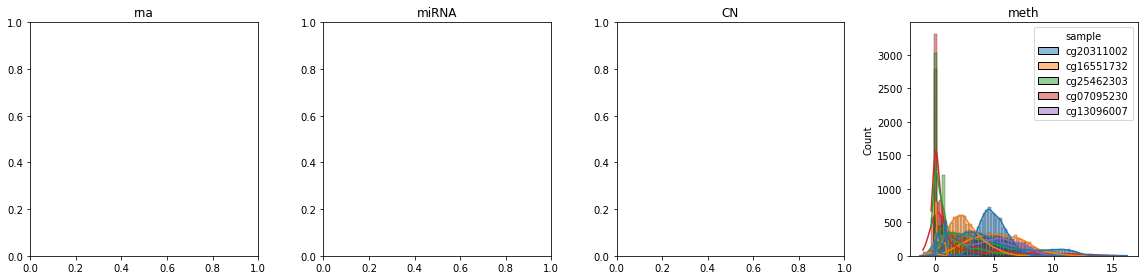

In [17]:
fig, axs = plt.subplots(ncols=4, figsize=(16, 4))
for i, fn in enumerate(save_fns):
    name = os.path.basename(fn)[:-4]
    df = pd.read_csv(fn, index_col=0).T
    print("%s, max: %.4f, min:%.4f" % (name, df.values.max(), df.values.min()))
    df = df.sample(5, axis=1)
    sns.histplot(df, kde=True)
    axs[i].set_title(name)
fig.tight_layout()
plt.show()

# df = pd.read_csv("/mnt/data1/share_data/TCGA/data_for_cluster/pancancer-unnormed/fea/PAN/rna.fea", index_col=0)
# df = df.T
# print("max: %.4f, min:%.4f" % (df.values.max(), df.values.min()))
# df = df.sample(5, axis=1)
# df.plot.kde()

# Preprocess Subcancer Dataset

## preprocess clinical variables

In [143]:
ori_clinic_dir = "/mnt/data1/share_data/TCGA/data_for_cluster/SubtypeGAN/clinic-ori/"
save_clinic_dir = "/mnt/data1/share_data/TCGA/data_for_cluster/SubtypeGAN/clinic/"
os.makedirs(save_clinic_dir)

In [145]:
for fn in os.listdir(ori_clinic_dir):
    fullfn = os.path.join(ori_clinic_dir, fn)
    if not os.path.isfile(fullfn):
        continue
    clin_df = pd.read_csv(fullfn, index_col=0)
    # 处理缺失值
    clin_df.replace(NA_MAP, inplace=True)
    # 将stage中的值进行替换
    clin_df.replace({"pathologic_stage": STAGE_MAP}, inplace=True)
    clin_df.replace({"pathologic_T": T_MAP}, inplace=True)
    clin_df.replace({"pathologic_N": N_MAP}, inplace=True)
    clin_df.replace({"pathologic_M": M_MAP}, inplace=True)
    for col in clin_df.columns:
        if col in [
            "status", "days", "age_at_initial_pathologic_diagnosis"
        ]:
            clin_df[col] = clin_df[col].astype("float")
    clin_df.to_csv(os.path.join(save_clinic_dir, fn))
    print("%s finish." % fn)

SKCM.clinic finish.
BRCA.clinic finish.
PAAD.clinic finish.
STAD.clinic finish.
UCEC.clinic finish.
UVM.clinic finish.
BLCA.clinic finish.
GBM.clinic finish.
LUAD.clinic finish.
KIRC.clinic finish.


## glance

In [28]:
root = "/mnt/data1/share_data/TCGA/data_for_cluster/SubtypeGAN/fea/BRCA/"
dfs = {}
for k in ["meth", "rna", "miRNA", "CN"]:
    fn = os.path.join(root, "%s.fea" % k)
    dfs[k] = pd.read_csv(fn, index_col=0).T
    
print(", ".join(["%s: %s" % (k, df.shape) for k, df in dfs.items()]))

meth: (1031, 3139), rna: (1031, 3217), miRNA: (1031, 383), CN: (1031, 3105)


In [29]:
dfs["rna"].head()

gene_id,A2BP1|54715,A2ML1|144568,ACTL6B|51412,ADAM6|8755,ADAMDEC1|27299,ALDH1A3|220,ATCAY|85300,ATP10B|23120,BCAS1|8537,C10orf105|414152,...,SLC38A5|92745,SLC44A3|126969,SSX4|6759,TMEM200B|399474,TMEM26|219623,TNFRSF10D|8793,XAF1|54739,YJEFN3|374887,ZMAT1|84460,ZNF415|55786
TCGA-D8-A1XJ,-1.069946,0.255748,-1.253764,1.949321,-0.219076,1.138533,-1.151084,-0.712476,0.727775,-0.097461,...,0.464742,0.728496,-1.253764,0.100336,0.309140,-0.137741,1.049927,0.130878,0.243419,0.919743
TCGA-EW-A6SA,-1.075002,-0.877250,-1.075002,2.603630,-0.343607,0.290696,-1.075002,-1.075002,1.803777,-0.805499,...,0.006730,-0.186337,-1.075002,0.074355,1.559700,-0.031195,0.804427,0.756975,1.665578,0.998233
TCGA-D8-A27H,-1.377040,1.623317,-1.377040,2.016646,-0.110169,2.239296,-1.377040,-0.463145,-0.220050,-0.200492,...,0.817090,1.172278,-1.377040,0.899839,0.060782,0.859278,0.861333,-0.247407,0.577364,0.488567
TCGA-E9-A247,-1.307689,-1.307689,-1.307689,1.936839,0.410611,0.755849,-1.203306,-1.120093,1.467747,-0.852332,...,0.416114,0.612478,-1.307689,-0.101662,0.742294,-0.108815,2.059151,0.344370,1.566749,0.962162
TCGA-AC-A2FG,-1.292405,-0.718106,-1.458347,2.851206,-0.181777,1.327123,-1.366792,-0.449586,1.138774,-0.341951,...,0.052516,0.962489,-1.458347,0.345894,1.581451,0.400406,0.873924,-0.134025,1.015788,0.684443


In [31]:
dfs["rna"].index[:5]

Index(['TCGA-D8-A1XJ', 'TCGA-EW-A6SA', 'TCGA-D8-A27H', 'TCGA-E9-A247',
       'TCGA-AC-A2FG'],
      dtype='object')

In [32]:
del dfs

In [33]:
fn = "/mnt/data1/share_data/TCGA/data_for_cluster/SubtypeGAN/clinic-ori/BRCA.clinic"
df = pd.read_csv(fn, index_col=0)
df.head()

,status,days,gender,age_at_initial_pathologic_diagnosis,pathologic_M,pathologic_N,pathologic_T,pathologic_stage
bcr_patient_barcode,,,,,,,,
TCGA-D8-A1XJ,0,663.0,FEMALE,76,MX,N1a,T3,Stage IIIA
TCGA-EW-A6SA,0,510,MALE,59,MX,N0 (i+),T2,Stage II
TCGA-D8-A27H,0,397.0,FEMALE,72,M0,N0,T2,Stage IIA
TCGA-E9-A247,0,1186.0,FEMALE,59,M0,N0 (i-),T1c,Stage IA
TCGA-AC-A2FG,0,1853.0,FEMALE,79,MX,N1a,T2,Stage IIB


In [34]:
df.pathologic_stage.value_counts()

Stage IIA          336
Stage IIB          239
Stage IIIA         150
Stage I             87
Stage IA            80
Stage IIIC          63
Stage IIIB          27
Stage IV            19
Stage X             13
Stage II             5
[Not Available]      5
Stage IB             5
Stage III            2
Name: pathologic_stage, dtype: int64